In [1]:
import tensorflow as tf


gpus = tf.config.list_physical_devices('GPU')

print(f'Detected gpus: {gpus}')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print('Set dynamic GPU memory allocation.')

Detected gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Set dynamic GPU memory allocation.


2022-04-26 18:11:13.664149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 18:11:13.683144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 18:11:13.683783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
import os
import numpy as np
import pandas as pd
import wandb

from utils import PROJ_ROOT
from models import get_unet_generator
from dataset import url_dataset_for_G, download_imgs, get_xy_for_G, postprocess

from wandb.keras import WandbCallback

wandb.init(project="colorgan", tags=["baseline"])


wandb: Currently logged in as: markcheeky (use `wandb login --relogin` to force relogin)
/home/mk/.conda/envs/pa228-ml-images/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mk/.conda/envs/pa228-ml-images/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mk/.conda/envs/pa228-ml-images/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mk/.conda/envs/pa228-ml-images/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self.

In [3]:
list(tf.data.Dataset.range(0).as_numpy_iterator())

2022-04-26 18:11:19.102239: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-26 18:11:19.102872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 18:11:19.103588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 18:11:19.104133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, 

[]

In [4]:
df_train = pd.read_csv(f"{PROJ_ROOT}/open_images_v2/train/images.csv", nrows=1000)
print("load train set done.", df_train.shape)

df_valid = pd.read_csv(f"{PROJ_ROOT}/open_images_v2/validation/images.csv", nrows=1000)
print("load validation set done.", df_valid.shape)

df_test = pd.read_csv(f"{PROJ_ROOT}/open_images_v2/test/images.csv", nrows=1000)
print("load test set done.", df_test.shape)

load train set done. (1000, 11)
load validation set done. (1000, 11)
load test set done. (1000, 11)


In [5]:
cache_dir_valid = f"{PROJ_ROOT}/cache/valid"
cache_dir_test = f"{PROJ_ROOT}/cache/test"
os.makedirs(cache_dir_valid, exist_ok=True)
os.makedirs(cache_dir_test, exist_ok=True)


BATCH_SIZE = 16
WORKERS = 100
PREFETCH = 500

ds_train = url_dataset_for_G(
    df_train.ImageID.values[:100],
    df_train.OriginalURL.values[:100],
    augment=True,
    stride=(256, 256),
    repeats=200,
    prefetch=PREFETCH,
    download_workers=WORKERS,
).batch(BATCH_SIZE)

ds_valid = url_dataset_for_G(
    df_valid.ImageID.values,
    df_valid.OriginalURL.values,
    augment=False,
    use_cache=True,
    prefetch=PREFETCH,
    cache_dir=cache_dir_valid,
    download_workers=WORKERS,
).batch(BATCH_SIZE)

ds_test = url_dataset_for_G(
    df_test.ImageID.values,
    df_test.OriginalURL.values,
    augment=False,
    use_cache=True,
    prefetch=PREFETCH,
    cache_dir=cache_dir_test,
    download_workers=WORKERS,
).batch(BATCH_SIZE)

In [6]:
df_monitor = df_valid[:300].sample(frac=1, random_state=42)

ds_monitor = (
    url_dataset_for_G(
        df_monitor.ImageID.values,
        df_monitor.OriginalURL.values,
        augment=False,
        use_cache=True,
        cache_dir=cache_dir_valid,
    )
    .take(200)
    .shuffle(buffer_size=100, seed=0)
    .take(50)
    .batch(1)
)

ds_monitor = tf.data.Dataset.from_tensor_slices(tuple(map(np.concatenate, zip(*list(ds_monitor))))).batch(BATCH_SIZE)


2022-04-26 18:11:20.046165: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


('Response from https://farm5.staticflickr.com/4116/4763513986_36a7a8a00f_o.jpg has code 410', <Response [410]>)
('Response from https://c8.staticflickr.com/7/6217/6216026305_73dc7b494b_o.jpg has code 404', <Response [404]>)
('Response from https://farm2.staticflickr.com/7102/6886418522_4024994bc4_o.jpg has code 410', <Response [410]>)
('Response from https://farm6.staticflickr.com/57/191185533_77bcca0e80_o.jpg has code 404', <Response [404]>)
('Response from https://c6.staticflickr.com/8/7396/10181730734_54c24a2920_o.jpg has code 410', <Response [410]>)


In [7]:
ds_monitor

<BatchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 3)), types: (tf.float32, tf.float32)>

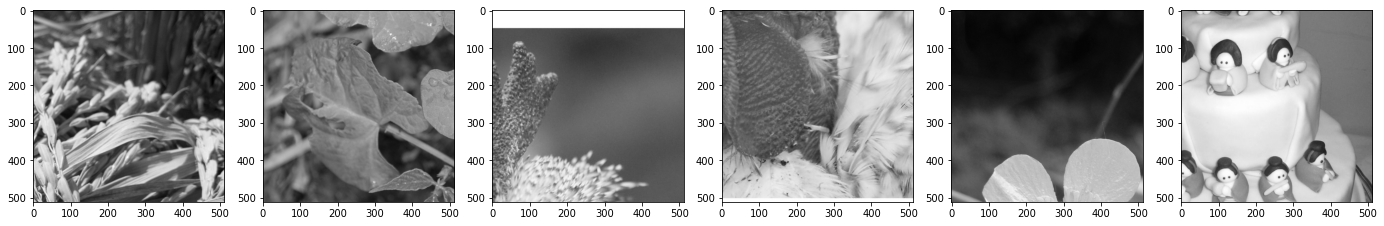

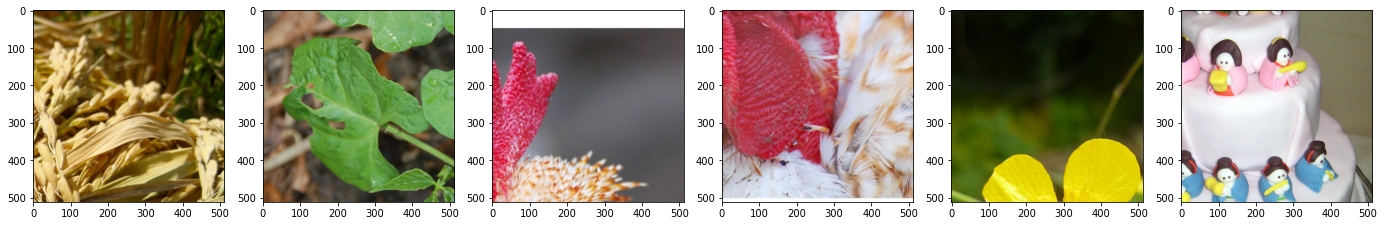

In [8]:
import matplotlib.pyplot as plt
from skimage.io import imshow


limit = 6
f, axarrx = plt.subplots(1, limit, figsize=(limit*4, 4)) 
f, axarry = plt.subplots(1, limit, figsize=(limit*4, 4)) 

for i, (x, y) in enumerate(ds_monitor.unbatch().take(limit)):
    axarrx[i].imshow(postprocess(x.numpy()))
    axarry[i].imshow(postprocess(y.numpy()))

In [9]:
g = get_unet_generator()

In [10]:
g.compile(optimizer="adam", loss="mae")

In [11]:
preds = g.predict(ds_monitor)

2022-04-26 18:11:25.497085: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-04-26 18:11:26.169927: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-26 18:11:26.172554: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-26 18:11:26.172575: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-04-26 18:11:26.175162: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-26 18:11:26.175204: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [12]:
class LogPredictionsCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset: tf.data.Dataset, name: str = "visualization") -> None:
        self.name = name
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None) -> None:

        table = wandb.Table(columns=["x", "pred", "y"])
        preds = self.model.predict(self.dataset)

        for pred, (x, y) in zip(preds, self.dataset.unbatch()):
            table.add_data(
                wandb.Image(postprocess(x.numpy())),
                wandb.Image(postprocess(pred)),
                wandb.Image(postprocess(y.numpy())),
            )

        wandb.log({self.name: table})


In [13]:
model_name = "baseline_v4"
model_path = f"{PROJ_ROOT}/models/{model_name}"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor="val_loss",
    save_best_only=True,
    save_freq=10000,
)

wandb_callback = WandbCallback()

visualization_callback = LogPredictionsCallback(ds_monitor)

In [14]:
g.fit(
    ds_train,
    epochs=3,
    validation_data=ds_valid,
    validation_freq=1,
    steps_per_epoch=200,
    use_multiprocessing=True,
    workers=6,
    verbose=1,
    callbacks=[
        model_checkpoint_callback,
        wandb_callback,  
        visualization_callback
    ]
)

Epoch 1/3
('Response from https://c6.staticflickr.com/4/3836/15059991712_d02d910225_o.jpg has code 410', <Response [410]>)
('Response from https://c5.staticflickr.com/9/8670/16659811280_645e27e5c3_o.jpg has code 410', <Response [410]>)
('Response from https://farm4.staticflickr.com/1282/4599122146_550ac7f976_o.jpg has code 404', <Response [404]>)
('Response from https://c2.staticflickr.com/8/7038/6947057537_24fea839d0_o.jpg has code 404', <Response [404]>)
('Response from https://farm2.staticflickr.com/5649/20857399598_63843eeb4e_o.jpg has code 410', <Response [410]>)
('Response from https://c5.staticflickr.com/6/5590/14864523078_90da1581b4_o.jpg has code 410', <Response [410]>)
('Response from https://c7.staticflickr.com/8/7266/7630204884_f066e6b693_o.jpg has code 404', <Response [404]>)
('Response from https://farm5.staticflickr.com/5448/16575269053_a06b49d1be_o.jpg has code 404', <Response [404]>)
('Response from https://c3.staticflickr.com/6/5229/5682524083_4c81641ce1_o.jpg has cod

In [15]:
g.save(model_path)

2022-04-26 18:20:07.619960: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/mk/school/pa228-gan/models/baseline_v4/assets
